In [2]:
import os
import sys
import time

import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd.functional import jacobian
from torch.nn.utils.rnn import pad_sequence
from torchviz import make_dot
from tqdm import tqdm

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, parent_dir)

from src.dataloader import FastTensorDataLoader

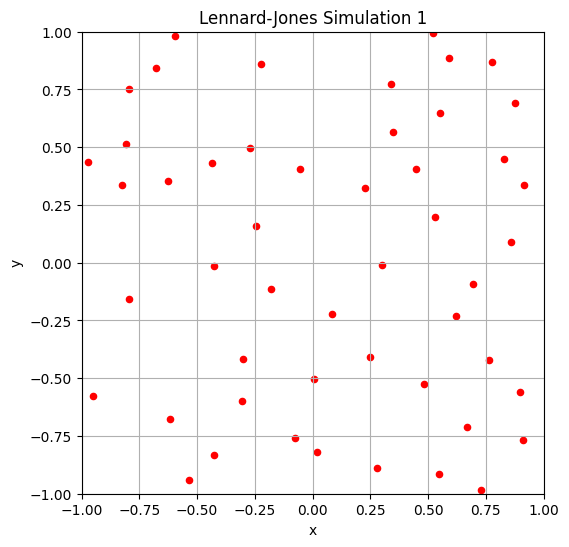

In [12]:
df = pd.read_csv("simulated_points_sftcr.csv")
# df = pd.read_csv("simulated_points_sftcr_new.csv")
# df = pd.read_csv("simulated_points_hom.csv")

samples = [torch.tensor(group[["x", "y"]].values, dtype=torch.float32) 
           for _, group in df.groupby("sim")]
# samples = [torch.tensor(group[["x", "y"]].iloc[:2].values, dtype=torch.float32) 
#            for _, group in df.groupby("sim")]
samples = tuple(samples)[:100]  # or use list if that suits your workflow

sim1 = samples[0]
plt.figure(figsize=(6, 6))
plt.scatter(sim1[:, 0], sim1[:, 1], color="red", s=20)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title("Lennard-Jones Simulation 1")
plt.xlabel("x")
plt.ylabel("y")
plt.gca().set_aspect("equal")
plt.grid(True)
plt.show()

In [13]:
beta = torch.tensor(100)
sigma = torch.tensor(0.15)
epsilon = torch.tensor(0.1)
scale = torch.tensor(0.5)
kappa = torch.tensor(400)
sigma0 = torch.tensor(0.1)

In [14]:
theta1 = 4*epsilon * (sigma / sigma0)**12
theta2 = 4*epsilon * (sigma / sigma0)**6

In [15]:
k = torch.sigmoid(torch.tensor(0.5))

## Data Loader

In [16]:
train_ratio = 0.8
batch_size = 32
samples_torch = [torch.tensor(s, dtype=torch.float32) for s in samples]

X = pad_sequence(samples_torch, batch_first=True, padding_value=0)

lengths = torch.tensor([len(s) for s in samples_torch], dtype=torch.int64)
lengths_expanded = lengths.unsqueeze(-1).expand(-1, X.shape[1])
X = torch.cat((X, lengths_expanded.unsqueeze(-1)), dim=-1)

m = len(X)
train_size = int(train_ratio * m)

X_train = X[:train_size]
X_test = X[train_size:]

loader_train = FastTensorDataLoader(X_train, batch_size=batch_size, shuffle=False)
loader_test = FastTensorDataLoader(X_test, batch_size=batch_size, shuffle=False)

C:\Users\79217\AppData\Local\Temp\ipykernel_30040\3960548823.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  samples_torch = [torch.tensor(s, dtype=torch.float32) for s in samples]


## Optimization function

In [17]:
def optimize_theta(loader_train, nn_model, num_epochs=1000, learning_rate=1e-3):
    """
    Optimizes the model parameters.

    Args:
        loader_train (DataLoader): DataLoader for training data.
        nn_model (callable): Function that creates the neural network model.
        num_epochs (int): Number of training epochs.
        learning_rate (float): Learning rate.

    Returns:
        dict: Contains the trained model, losses, and parameter values.
    """
    model = nn_model()
    optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate)
    
    avg_epoch_losses = []
    avg_epoch_real_losses = []
    param_history = {}  # Dictionary to hold lists of per-epoch parameter averages

    pbar = tqdm(range(num_epochs), desc="Training", unit="epoch")

    for _ in pbar:
        epoch_loss_sum = 0
        epoch_real_loss_sum = 0
        num_batches = len(loader_train)

        batch_param_values = {}  # Store param values per batch, reset each epoch

        start_time = time.time()
        for X_batch in loader_train:
            optimizer.zero_grad()

            x = X_batch[0]
            x.requires_grad_()
            loss, real_loss = model.loss(x)
            loss.backward()
            optimizer.step()

            epoch_loss_sum += loss.item()
            epoch_real_loss_sum += real_loss.item()

            # Collect current parameter values
            for name, param in model.named_parameters():
                if param.requires_grad:
                    value = param.detach().cpu().numpy().copy()
                    batch_param_values.setdefault(name, []).append(value)

        # Aggregate batch losses
        avg_loss = epoch_loss_sum / num_batches
        avg_real_loss = epoch_real_loss_sum / num_batches
        avg_epoch_losses.append(avg_loss)
        avg_epoch_real_losses.append(avg_real_loss)

        # Average each parameter across batches for this epoch
        for name, values in batch_param_values.items():
            avg_value = sum(values) / len(values)
            param_history.setdefault(name, []).append(avg_value)

        elapsed_time = time.time() - start_time
        pbar.set_postfix({
            "Train Loss": f"{avg_loss:.4f}",
            "Real Loss": f"{avg_real_loss:.4f}",
            "Time/Epoch": f"{elapsed_time:.2f}s"
        })

    return {
        "model": model,
        "avg_epoch_losses": avg_epoch_losses,
        "avg_epoch_real_losses": avg_epoch_real_losses,
        "param_history": param_history,
    }

In [284]:
class Gibbs(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(123)
        # intensity parameters
        self.scale = nn.Parameter(torch.abs(torch.randn(1)))
        # Lennard-Jones parameters
        # self.sigma = nn.Parameter(torch.abs(torch.randn(1)))
        # self.epsilon = nn.Parameter((torch.abs(torch.randn(1))))
        self.epsilon = nn.Parameter((torch.abs(torch.randn(1))))
        self.sigma = nn.Parameter((torch.abs(torch.randn(1))))

    def forward(self, x):
        epsilon = self.epsilon
        sigma = self.sigma
        diff = x[:, :, None, :] - x[:, None, :, :]
        sq_dist = torch.sum(diff ** 2, dim=-1)
        mask = sq_dist < 1e-6 # True where clamping will happen
        r = torch.sqrt(torch.clamp(sq_dist, min=1e-6))
        # r = torch.sqrt(sq_dist)
        
        phi = (4 * epsilon * ((sigma / r)**12 - (sigma / r)**6))
        phi[mask] = 0 
        energy = torch.sum(phi, dim=-1) / 2

        squared_norm = torch.sum(x**2, dim=-1)
        return - squared_norm / self.scale**2 - energy

    def compute_psi(self, x):
        x.requires_grad_()
        nn_output = self.forward(x)
        psi = torch.autograd.grad(nn_output, x, grad_outputs=torch.ones_like(nn_output), create_graph=True)[0]
        return psi
    
    def gibbs_psi(self, x):
        epsilon = self.epsilon
        sigma = self.sigma
        # x: (batch_size, num_points, 2)
        dx = x[:, :, 0].unsqueeze(2) - x[:, :, 0].unsqueeze(1)  # (batch, n, n)
        dy = x[:, :, 1].unsqueeze(2) - x[:, :, 1].unsqueeze(1)  # (batch, n, n)
        r = torch.sqrt(dx**2 + dy**2)
        
        phi = 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)
        mask = torch.isfinite(phi)
        phi[~mask] = 0  # Avoid NaN values

        # Gradient components
        grad_common_12 = -12 * sigma**12 * r**(-12)
        grad_common_6 = -6 * sigma**6 * r**(-6)

        grad_x = 4 * epsilon * (grad_common_12 - grad_common_6) * (dx / r)
        grad_y = 4 * epsilon * (grad_common_12 - grad_common_6) * (dy / r)

        # Zero-out invalid entries
        grad_x[~mask] = 0
        grad_y[~mask] = 0

        # Stack to get vector gradient per interaction
        # Shape: (batch_size, num_points, num_points, 2)
        grad_phi = torch.stack([grad_x, grad_y], dim=-1)

        # Sum over interactions to get net gradient per point
        # Shape: (batch_size, num_points, 2)
        gradient = grad_phi.sum(dim=2) / 2

        # Final force with regularization term
        return - 2 * x / self.scale**2 - gradient
    
    def J(self, x_t, lengths):
        max_length = lengths.max()
        psi_x = self.gibbs_psi(x_t)  

        norm_squared = (psi_x ** 2).sum(dim=-1) 

        divergence = -2 / self.scale**2 * x_t.shape[-1]
        mask = torch.arange(max_length, device=x_t.device).unsqueeze(0) < lengths.unsqueeze(1)
        divergence = divergence*mask
        norm_squared = norm_squared*mask

        J_value = divergence + 0.5 * norm_squared
        J_value = J_value.sum(dim=-1) / lengths

        return J_value.mean()

    def loss(self, points):
        lengths = points[:, 0, -1].to(dtype=torch.int64)
        max_length = lengths.max()
        x_t = points[:, :max_length, :-1]  # Pad to max length in batch
 
        psi_x = self.compute_psi(x_t)
        psi_x_real = self.gibbs_psi(x_t)

        # if not torch.allclose(psi_x, psi_x_real, atol=1e-2):
        #     difference = psi_x - psi_x_real
        #     raise ValueError(f"Difference between calculated psi value and analytical solution: \n{difference}")
        norm_squared = (psi_x ** 2).sum(dim=-1)  # Sum across all dimensions

        # padded values give none zero divergence -> mask 
        mask = torch.arange(max_length, device=x_t.device).unsqueeze(0) < lengths.unsqueeze(1)
        divergence = 0
        for i in range(x_t.shape[-1]):  # Iterate over the features of x
            gradient = torch.autograd.grad(psi_x[..., i].sum(), x_t, retain_graph=True, create_graph=True)[0]
            divergence += gradient[..., i]  # Sum over each feature dimension
        
        divergence = divergence * mask
        norm_squared = norm_squared * mask
        
        total_loss = 0.5 * norm_squared + divergence
        total_loss = total_loss.sum(dim=-1)/lengths  # Sum over the time dimension
        J = self.J(x_t, lengths)
        # if not torch.allclose(total_loss.mean(), J, atol=1e-2):
        #     raise ValueError(f"Calculated total loss value {total_loss.mean()}\n is different from the analytical solution {J}")
        return total_loss.mean(), J

In [285]:
class Gibbs(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(123)
        # intensity parameters
        self.scale = nn.Parameter(torch.abs(torch.randn(1)))
        # Lennard-Jones parameters
        self.theta1 = nn.Parameter((torch.abs(torch.randn(1))))
        self.theta2 = nn.Parameter((torch.abs(torch.randn(1))))

    def forward(self, x):
        diff = x[:, :, None, :] - x[:, None, :, :]
        sq_dist = torch.sum(diff ** 2, dim=-1)
        mask = sq_dist < 1e-6 # True where clamping will happen
        r = torch.sqrt(torch.clamp(sq_dist, min=1e-6))
        # r = torch.sqrt(sq_dist)

        sigma0 = torch.min(r[~mask])
        
        inv_r = sigma0 / r
        inv_r6 = inv_r ** 6
        inv_r12 = inv_r6 ** 2

        phi = self.theta1 * inv_r12 - self.theta2 * inv_r6
        phi = phi.masked_fill(mask, 0)

        energy = torch.sum(phi, dim=-1) / 2
        squared_norm = torch.sum(x**2, dim=-1)

        return -squared_norm / self.scale**2 - energy

    def compute_psi(self, x):
        x.requires_grad_()
        nn_output = self.forward(x)
        psi = torch.autograd.grad(nn_output, x, grad_outputs=torch.ones_like(nn_output), create_graph=True)[0]
        return psi
    
    def gibbs_psi(self, x):
        # x: (batch_size, num_points, 2)
        dx = x[:, :, 0].unsqueeze(2) - x[:, :, 0].unsqueeze(1)  # (batch, n, n)
        dy = x[:, :, 1].unsqueeze(2) - x[:, :, 1].unsqueeze(1)  # (batch, n, n)
        r = torch.sqrt(dx**2 + dy**2)

        sigma0 = torch.min(r)
        
        # Compute inverse powers
        inv_r = sigma0 / r
        inv_r6 = inv_r ** 6
        inv_r12 = inv_r6 ** 2

        # Potential energy
        phi = self.theta1 * inv_r12 - self.theta2 * inv_r6

        # Gradient components
        grad_common = (-12 * self.theta1 * inv_r12 + 6 * self.theta2 * inv_r6) / r

        grad_x = grad_common * dx
        grad_y = grad_common * dy

        # Zero-out invalid entries
        mask_x = torch.isfinite(grad_x)
        mask_y = torch.isfinite(grad_y)
        grad_x = grad_x.masked_fill(~mask_x, 0)
        grad_y = grad_y.masked_fill(~mask_y, 0)

        # Stack to get vector gradient per interaction
        grad_phi = torch.stack([grad_x, grad_y], dim=-1)  # (batch, n, n, 2)

        # Sum over interactions to get net gradient per point
        gradient = grad_phi.sum(dim=2) / 2  # (batch, n, 2)

        # Final force with regularization term
        return -2 * x / self.scale**2 - gradient
    
    def J(self, x_t, lengths):
        max_length = lengths.max()
        psi_x = self.gibbs_psi(x_t)  

        norm_squared = (psi_x ** 2).sum(dim=-1) 

        divergence = -2 / self.scale**2 * x_t.shape[-1]
        mask = torch.arange(max_length, device=x_t.device).unsqueeze(0) < lengths.unsqueeze(1)
        divergence = divergence*mask
        norm_squared = norm_squared*mask

        J_value = divergence + 0.5 * norm_squared
        J_value = J_value.sum(dim=-1) / lengths

        return J_value.mean()

    def loss(self, points):
        lengths = points[:, 0, -1].to(dtype=torch.int64)
        max_length = lengths.max()
        x_t = points[:, :max_length, :-1]  # Pad to max length in batch
 
        psi_x = self.compute_psi(x_t)
        psi_x_real = self.gibbs_psi(x_t)

        # if not torch.allclose(psi_x, psi_x_real, atol=1e-2):
        #     difference = psi_x - psi_x_real
        #     raise ValueError(f"Difference between calculated psi value and analytical solution: \n{difference}")
        norm_squared = (psi_x ** 2).sum(dim=-1)  # Sum across all dimensions

        # padded values give none zero divergence -> mask 
        mask = torch.arange(max_length, device=x_t.device).unsqueeze(0) < lengths.unsqueeze(1)
        divergence = 0
        for i in range(x_t.shape[-1]):  # Iterate over the features of x
            gradient = torch.autograd.grad(psi_x[..., i].sum(), x_t, retain_graph=True, create_graph=True)[0]
            divergence += gradient[..., i]  # Sum over each feature dimension
        
        divergence = divergence * mask
        norm_squared = norm_squared * mask
        
        total_loss = 0.5 * norm_squared + divergence
        total_loss = total_loss.sum(dim=-1)/lengths  # Sum over the time dimension
        J = self.J(x_t, lengths)
        # if not torch.allclose(total_loss.mean(), J, atol=1e-2):
        #     raise ValueError(f"Calculated total loss value {total_loss.mean()}\n is different from the analytical solution {J}")
        return total_loss.mean(), J

In [ ]:
class Gibbs_Softcore(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(123)
        # intensity parameters
        self.scale = nn.Parameter(torch.abs(torch.randn(1)))
        # Lennard-Jones parameters
        self.sigma = nn.Parameter(torch.abs(torch.randn(1)))
        self.k_raw = nn.Parameter(torch.abs(torch.randn(1)))

    @property
    def k(self):
        # return torch.sigmoid(self.k_raw)
        return self.k_raw

    def forward(self, x):
        _, N, _ = x.shape
        i_idx, j_idx = torch.triu_indices(N, N, offset=1)

        xi = x[:, i_idx, :]
        xj = x[:, j_idx, :]
        diff = xi - xj
        sq_dist = torch.sum(diff ** 2, dim=-1)
        r = torch.sqrt(sq_dist + 1e-10)  # Avoid divide-by-zero
        # r = torch.cdist(xi, xj, p=2)

        # sigma = torch.exp(self.sigma)
        sigma = self.sigma
        phi = torch.pow(sigma / r, 2 / self.k)

        # Sum over i < j interactions
        energy = phi.sum(dim=-1)

        squared_norm = torch.sum(x**2, dim=-1).sum(dim=-1)
        return - squared_norm / self.scale**2 - energy
        # return -energy

    def compute_psi(self, x):
        nn_output = self.forward(x)
        grad_outputs = torch.ones_like(nn_output)
        psi = torch.autograd.grad(
            nn_output, x,
            grad_outputs=grad_outputs, retain_graph=True, create_graph=True
        )[0]
        return psi
    
    def sftcr_psi(self, x):
        B, N, D = x.shape

        i_idx, j_idx = torch.triu_indices(N, N, offset=1, device=x.device)  # i < j

        xi = x[:, i_idx, :]  # Shape: (B, M, 2)
        xj = x[:, j_idx, :]

        dx = xi - xj  # Shape: (B, M, 2)
        r = torch.sqrt(torch.sum(dx**2, dim=-1) + 1e-10)  # Shape: (B, M)

        sigma = torch.exp(self.sigma)
        sigma = self.sigma
        k = self.k

        frac = sigma / r
        power = frac ** (2 / k)
        factor = (2 / k) * power / (r**2)

        force = factor.unsqueeze(-1) * dx

        # Initialize gradient accumulator
        grad = torch.zeros_like(x)

        # Scatter forces: +F to i, -F to j
        grad.index_add_(1, i_idx, force)
        grad.index_add_(1, j_idx, -force)

        return -2 * x / (self.scale ** 2) + grad
        # return grad

    def J(self, x):
        B, N, D = x.shape
        i_idx, j_idx = torch.triu_indices(N, N, offset=1, device=x.device)
        
        psi_x = self.sftcr_psi(x)
        norm_squared = psi_x.square().sum(dim=-1)  # (B, N)

        xi, xj = x[:, i_idx], x[:, j_idx]
        diff = xi - xj
        r2 = diff.square().sum(dim=-1) + 1e-10  # (B, M)
        r = r2.sqrt()

        # sigma = torch.exp(self.sigma)
        sigma = self.sigma
        k = self.k
        phi = (sigma / r).pow(2 / k).unsqueeze(-1).unsqueeze(-1)

        diff_outer = diff.unsqueeze(-1) @ diff.unsqueeze(-2)  # (B, M, D, D)
        I = torch.eye(D, device=x.device).view(1, 1, D, D)
        r2_ = r2.unsqueeze(-1).unsqueeze(-1)
        r4 = r2_ ** 2

        term = I / r2_ - ((2 / k + 2) * diff_outer / r4)
        div_phi_matrix = (2 / k) * phi * term
        div_phi = div_phi_matrix.diagonal(dim1=-2, dim2=-1).sum(-1)  # (B, M)

        interaction_div = torch.zeros(B, N, device=x.device)
        for idx in (i_idx, j_idx):
            interaction_div.index_add_(1, idx, div_phi)
        divergence = -2 / self.scale**2 * x.shape[-1] + interaction_div
        # divergence = interaction_div

        return divergence, norm_squared

    def loss(self, points):
        lengths = points[:, 0, -1].to(dtype=torch.int64)
        max_length = lengths.max()
        x_t = points[:, :max_length, :-1]  # Pad to max length in batch
 
        psi_x = self.compute_psi(x_t)
        psi_x_real = self.sftcr_psi(x_t)

        threshold = 1e-2
        if not torch.allclose(psi_x, psi_x_real, atol=threshold):
            difference = psi_x - psi_x_real
            mask = torch.abs(difference) > threshold
            exceeded = difference[mask]
            raise ValueError(
                f"Difference between calculated psi value and analytical solution exceeds threshold {threshold} at the following positions:\n"
                f"Indices: {mask.nonzero(as_tuple=True)}\n"
                f"Differences: {exceeded}"
           )
        
        norm_squared = (psi_x ** 2).sum(dim=-1)  # Sum across all dimensions

        divergence = torch.zeros(x_t.shape[0], x_t.shape[1])
        for d in range(x_t.shape[-1]):
            for i in range(x_t.shape[-2]):
                second_grad = torch.autograd.grad(
                     psi_x[:, i, d].sum(), x_t, create_graph=True)[0][:, i, d]  # shape: (B,)
                divergence[:, i] += second_grad

        # padded values give none zero divergence -> mask 
        mask = torch.arange(max_length).unsqueeze(0) < lengths.unsqueeze(1)
        divergence = divergence * mask
        norm_squared = norm_squared * mask

        divergence_real, norm_squared_real = self.J(x_t)
        divergence_real = divergence_real * mask
        norm_squared_real = norm_squared_real * mask

        if not torch.allclose(divergence, divergence_real, atol=threshold):
            difference = divergence - divergence_real
            mask = torch.abs(difference) > threshold
            exceeded = difference[mask]
            raise ValueError(
                f"Difference between calculated divergence value and analytical solution exceeds threshold {threshold} at the following positions:\n"
                f"Indices: {mask.nonzero(as_tuple=True)}\n"
                f"Differences: {exceeded}"
            )
        
        total_loss = 0.5 * norm_squared + divergence
        total_loss = total_loss.sum(dim=-1)/lengths  # Sum over the time dimension

        J = 0.5 * norm_squared_real + divergence_real
        J = J.sum(dim=-1) / lengths
        return total_loss.mean(), J.mean()

In [24]:
torch.autograd.set_detect_anomaly(True)
epochs = 100
results = optimize_theta(
    loader_train, Gibbs_Softcore, num_epochs=epochs, learning_rate=1e-3,
)

Training:  53%|█████▎    | 53/100 [08:17<06:18,  8.06s/epoch, Train Loss=-23721.0020, Real Loss=-23721.0078, Time/Epoch=7.95s]c:\Users\79217\Documents\TUD\3 semester\Research Project\poisson_inference\.venv_clean\Lib\site-packages\torch\autograd\graph.py:824: UserWarning: Error detected in IndexBackward0. Traceback of forward call that caused the error:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\79217\Documents\TUD\3 semester\Research Project\poisson_inference\.venv_clean\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\79217\Documents\TUD\3 semester\Research Project\poisson_inference\.venv_clean\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\79217\Documents\TUD\3 semester\Research Project\poisson_inference\.venv_clean\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
 

RuntimeError: Function 'IndexBackward0' returned nan values in its 0th output.

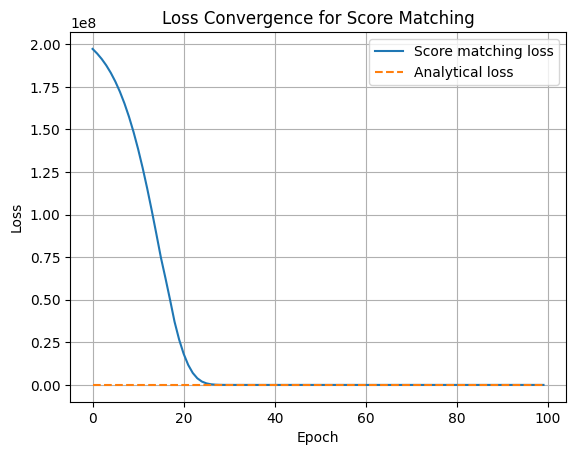

In [20]:
plt.plot(results["avg_epoch_losses"], label="Score matching loss")
plt.plot(results["avg_epoch_real_losses"], linestyle='--', label="Analytical loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence for Score Matching')
plt.legend()    
plt.grid(True)
plt.show()

C:\Users\79217\AppData\Local\Temp\ipykernel_30040\3243120163.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  ax.plot(torch.exp(torch.tensor(values)), label=f"Estimated {param_name}")


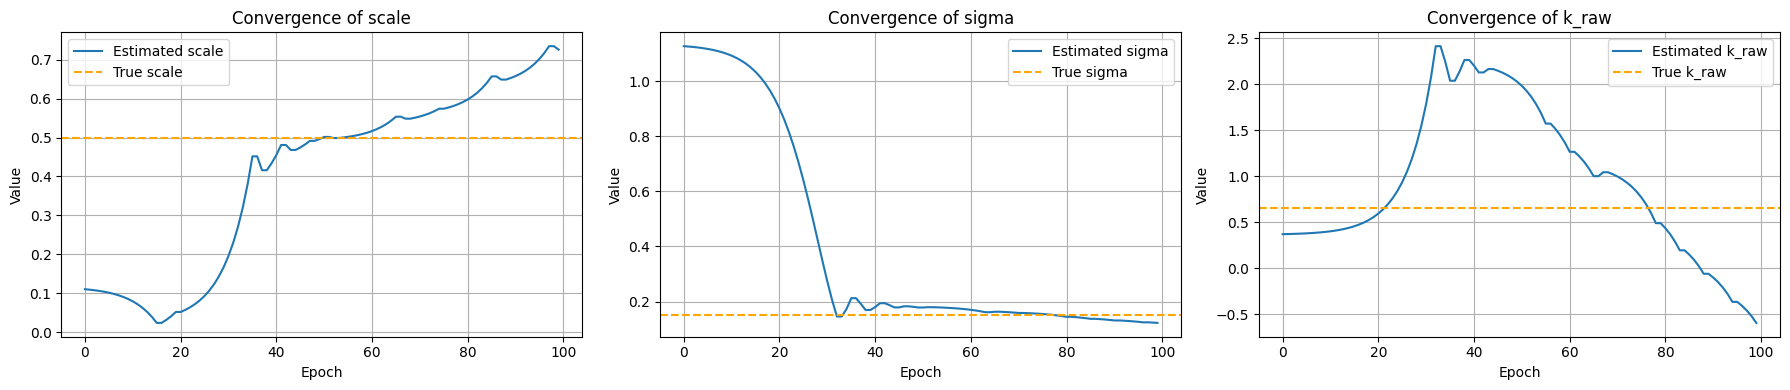

In [21]:
def plot_param_convergence(param_history, true_params=None):
    """
    Plots the convergence of parameters over epochs.

    Args:
        param_history (dict): Dictionary where keys are parameter names and values are lists of per-epoch averages.
        true_params (dict, optional): Dictionary of true parameter values to plot as horizontal lines.
    """
    num_params = len(param_history)
    fig, axs = plt.subplots(1, num_params, figsize=(6 * num_params, 4))

    if num_params == 1:
        axs = [axs]  # Ensure axs is iterable if there's only one subplot

    for ax, (param_name, values) in zip(axs, param_history.items()):
        if param_name == "sigma":
            ax.plot(torch.exp(torch.tensor(values)), label=f"Estimated {param_name}")
        else:
            ax.plot(values, label=f"Estimated {param_name}")
        if true_params and param_name in true_params:
            ax.axhline(true_params[param_name], color='orange', linestyle='--', label=f"True {param_name}")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Value')
        ax.set_title(f'Convergence of {param_name}')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# plot_param_convergence(results["param_history"], true_params={"scale": scale, "sigma": sigma, "epsilon": epsilon})
# plot_param_convergence(results["param_history"], true_params={"scale": scale, "theta1": theta1, "theta2": theta2})
plot_param_convergence(results["param_history"], true_params={"scale": scale, "k_raw": torch.sigmoid(k), "sigma": sigma})

In [22]:
print("Final scale: ", results["param_history"]["scale"][-1][0])
print("Final sigma: ", torch.exp(torch.tensor(results["param_history"]["sigma"][-1])).item())
print("Final k: ", torch.sigmoid(torch.tensor(results["param_history"]["k_raw"][-1])).item())

Final scale:  0.72565174
Final sigma:  0.12269122153520584
Final k:  0.3556188941001892


In [389]:
def minimal_test(x):
    xi = x[:, 0, :]
    xj = x[:, 1, :]
    diff = xi - xj
    r = torch.sqrt(torch.sum(diff ** 2, dim=-1) + 1e-10)
    sigma = torch.exp(torch.tensor(0.15))
    k = torch.sigmoid(torch.tensor(0.5))
    phi = torch.pow(sigma / r, 2 / k)
    
    energy = phi.sum(dim=-1)
    return - energy

# Forward pass
x_t = torch.tensor([[[ 0.4806, -0.5267], [ 0.5513,  0.6484]]], requires_grad=True)  # Simplified input, shape (B, N, D)

def psi(x_t):
    output = minimal_test(x_t)
    gradients = torch.autograd.grad(
        outputs=output, inputs=x_t, grad_outputs=torch.ones_like(output),
        retain_graph=True, create_graph=True,
    )[0]
    return gradients

gradients = psi(x_t)
grad_outputs = torch.ones_like(gradients)
divergence = torch.autograd.grad(outputs=gradients, inputs=x_t, grad_outputs=grad_outputs, create_graph=True)[0]
print("Gradients:", gradients)
print("Second Gradients (autograd):", divergence)

jac = jacobian(psi, x_t)
print(jac)

divergence = torch.zeros(x_t.shape[:-1], device=x_t.device)  # shape: (B, N)
for b in range(x_t.shape[0]):
    for n in range(x_t.shape[1]):
        # Jacobian at point (b, n) is D x D
        J = jac[b, n, :, b, n, :]  # shape: (D, D)
        divergence[b, n] = torch.trace(J)

print("Second Gradients (jacobian):", divergence)

divergence = torch.zeros(x_t.shape[:-1], device=x_t.device)  # shape: (B, N)
for b in range(x_t.shape[0]):
    for n in range(x_t.shape[1]):
        for d in range(x_t.shape[2]):
            divergence[b, n] += torch.autograd.grad(
                gradients[b, n, d], x_t, retain_graph=True, create_graph=True,
            )[0][b, n, d]


print("Second Gradients (autograd per input):", divergence)


Gradients: tensor([[[-0.1571, -2.6116],
         [ 0.1571,  2.6116]]], grad_fn=<AddBackward0>)
Second Gradients (autograd): tensor([[[0., 0.],
         [0., 0.]]], grad_fn=<AddBackward0>)
tensor([[[[[[ 2.1807, -0.6946],
            [-2.1807,  0.6946]]],


          [[[-0.6946, -9.3216],
            [ 0.6946,  9.3216]]]],



         [[[[-2.1807,  0.6946],
            [ 2.1807, -0.6946]]],


          [[[ 0.6946,  9.3216],
            [-0.6946, -9.3216]]]]]])
Second Gradients (jacobian): tensor([[-7.1409, -7.1409]])
Second Gradients (autograd per input): tensor([[-7.1409, -7.1409]], grad_fn=<CopySlices>)


In [442]:
# divergence = torch.zeros_like(x_t[..., 0])  # shape (B, N)

# def psi(x_t):
#     psi_x = self.compute_psi(x_t)
#     return psi_x

jac = jacobian(psi, x_t)

divergence = torch.zeros_like(jac, device=x_t.device)  # shape: (B, N)
for b in range(x_t.shape[0]):
    for n in range(x_t.shape[1]):
        # Jacobian at point (b, n) is D x D
        J = jac[b, n, :, b, n, :]  # shape: (D, D)
        print(J.shape)
        divergence[b, n] = J

# divergence = torch.zeros_like(x_t[..., 0])  # shape: (B, N)

# for b in range(x_t.shape[0]):
#     for n in range(x_t.shape[1]):
#         for d in range(x_t.shape[2]):
#             divergence[b, n] += torch.autograd.grad(
#                 psi_x[b, n, d], x_t, create_graph=True,
#             )[0][b, n, d]


torch.Size([2, 2])
torch.Size([2, 2])


In [ ]:
import numpy as np

# Given input
x = np.array([
    [0.4806, -0.5267],
    [0.5513,  0.6484]
])

sigma = torch.exp(torch.tensor(0.15))
k = torch.sigmoid(torch.tensor(0.5))

# Pairwise difference
diff = x[1] - x[0]
r2 = np.sum(diff ** 2)
r4 = r2 ** 2

# Precompute constants
sigma_pow = sigma ** (2 / k)
prefactor = 2 / k
power_term = 2 / k + 2
term1 = 1 / r2 ** (2 / k + 2)

# Compute second derivative for each coordinate
second_derivatives = []
for i in range(2):  # x and y coordinates
    xi_minus_xj = x[0, i] - x[1, i]
    term2 = power_term * (xi_minus_xj ** 2) / r4
    d2 = prefactor * sigma_pow * (term1 - term2)
    second_derivatives.append(d2)

second_derivatives = np.array(second_derivatives)
second_derivatives


array([  0.8787969, -18.550673 ], dtype=float32)

In [41]:
(x[0, 0] - x[1, 0]), (x[0, 1] - x[1, 1])

(np.float64(-0.07069999999999999), np.float64(-1.1751))

In [50]:
x_t = torch.tensor([[[ 0.4806, -0.5267], [ 0.5513,  0.6484],  [ 0.5513,  0.6484]]], requires_grad=True)  # Simplified input, shape (B, N, D)
B, N, D = x_t.shape
i_idx, j_idx = torch.triu_indices(N, N, offset=1, device=x.device)


xi, xj = x_t[:, i_idx], x_t[:, j_idx]
diff = xi - xj
r2 = diff.square().sum(dim=-1) + 1e-10  # (B, M)
r = r2.sqrt()

sigma = torch.exp(torch.tensor(0.15))
k = torch.sigmoid(torch.tensor(0.5))
phi = (sigma / r).pow(2 / k).unsqueeze(-1).unsqueeze(-1)

diff_outer = diff.square()
I = torch.eye(D, device=x.device).view(1, 1, D, D)
r2_ = r2.unsqueeze(-1).unsqueeze(-1)
r4 = r2_ ** 2

term = 1/ r2_ - ((2 / k + 2) * diff_outer / r4)
div_phi_matrix = (2 / k) * phi * term
print(div_phi_matrix)

interaction_div = torch.zeros(B, N, device=x.device)
for idx in (i_idx, j_idx):
    interaction_div.index_add_(1, idx, div_phi)
interaction_div

tensor([[[[ 2.1807e+00, -9.3216e+00],
          [ 2.1807e+00, -9.3216e+00],
          [ 2.2225e+00,  2.2225e+00]],

         [[ 2.1807e+00, -9.3216e+00],
          [ 2.1807e+00, -9.3216e+00],
          [ 2.2225e+00,  2.2225e+00]],

         [[-1.5757e+35, -4.3529e+37],
          [-1.5757e+35, -4.3529e+37],
          [ 6.0470e+26,  6.0470e+26]]]], grad_fn=<MulBackward0>)


RuntimeError: index_add_(): Number of indices (3) should be equal to source.size(dim): (1), for dim: 1

In [34]:
diff.unsqueeze(-1) * diff.unsqueeze(-2) 

tensor([[[[0.0050, 0.0831],
          [0.0831, 1.3809]]]], grad_fn=<MulBackward0>)

In [35]:
xi_minus_xj

np.float64(-1.1751)

In [36]:
xi, xj

(tensor([[[ 0.4806, -0.5267]]], grad_fn=<IndexBackward0>),
 tensor([[[0.5513, 0.6484]]], grad_fn=<IndexBackward0>))

In [37]:
diff.square()

tensor([[[0.0050, 1.3809]]], grad_fn=<PowBackward0>)